<a href="https://colab.research.google.com/github/m3sibti/DL_projects/blob/master/Keras_CycleGAN_mw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cycle-GAN

Image-to-Image Unpaired Translation

## Imports

In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.interpolation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image

## Prepare the dataset

In [2]:
(x_train, _), (x_test, _) = keras.datasets.fashion_mnist.load_data()

print('Training Samples ', x_train.shape)
print('Test Samples',x_test.shape)
x_data = np.vstack((x_train, x_test))
print('Combined Samples', x_data.shape)

4423680/4422102 [==============================] - 0s 0us/step
Training Samples  (60000, 28, 28)
Test Samples (10000, 28, 28)
Combined Samples (70000, 28, 28)


Find the mid point and rotate the other half to create a second domain Y against first half X

In [0]:
mid_point = int(x_data.shape[0]/2)

In [0]:
x_real = x_data[:mid_point]
x_real = x_real.reshape(-1, 28*28)
x_real = x_real.astype('float32')

In [0]:
x_rotated = x_data[mid_point:]
x_rotated = scipy.ndimage.interpolation.rotate(x_rotated, 90, axes=(1, 2))
x_rotated = x_rotated.reshape(-1, 28*28)

x_rotated = x_rotated.astype('float32')

In [6]:
x_real.shape, x_rotated.shape

((35000, 784), (35000, 784))

Visualize the Images

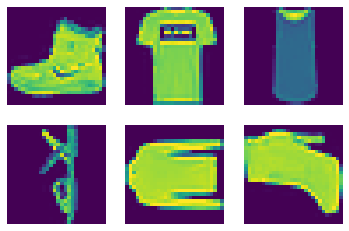

In [7]:
def show_images(x_real, x_rotated):
  fig, axs = plt.subplots(2, 3)
  [axi.set_axis_off() for axi in axs.ravel()]
  for i in range(3):
    x_img_real = x_real[i].reshape(28, 28)
    x_img_rotated = x_rotated[i].reshape(28, 28)
    axs[0][i].imshow(x_img_real)
    axs[1][i].imshow(x_img_rotated)

show_images(x_real, x_rotated)

Normalize the dataset and convert into single dataset object

In [0]:
x_real = x_real / 255.
x_rotated = x_rotated / 255.

In [0]:
data = tf.data.Dataset.from_tensor_slices((x_real, x_rotated))
data = data.shuffle(1024).batch(32).prefetch(16)

## Create Models

### Discriminators

In [0]:
Disc_X = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Disc_Y = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(1, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [11]:
print(Disc_X.summary())
print(Disc_Y.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
_________________________________________________________________
None


### Generators

In [0]:
Gen_G = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

Gen_F = models.Sequential([
                            keras.Input(shape=(784,)),
                            layers.Dense(128, activation='relu',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
                            layers.Dense(784, activation='sigmoid',
                                         kernel_initializer=keras.initializers.glorot_normal,
                                         bias_initializer=keras.initializers.glorot_normal),
])

In [13]:
print(Gen_G.summary())
print(Gen_F.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_5 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_7 (Dense)              (None, 784)               101136    
Total params: 201,616
Trainable params: 201,616
Non-trainable params: 0
_________________________________________________________________
None


## Override Training Step

In [0]:
class CycleGAN(models.Model):

  def __init__(self, disc_x, disc_y, gen_g, gen_f):
    super(CycleGAN, self).__init__()
    self.disc_x = disc_x
    self.disc_y = disc_y
    self.gen_g = gen_g
    self.gen_f = gen_f
    
  def compile(self, disc_x_opt, disc_y_opt, gen_g_opt, gen_f_opt,
              disc_loss, gen_loss, cycled_loss, iden_loss):
    super(CycleGAN, self).compile()
    self.disc_x_opt = disc_x_opt
    self.disc_y_opt = disc_y_opt
    self.gen_g_opt = gen_g_opt
    self.gen_f_opt = gen_f_opt
    self.disc_loss = disc_loss
    self.gen_loss = gen_loss
    self.cycled_loss = cycled_loss
    self.iden_loss = iden_loss

  def train_step(self, X):
    # real_x, real_y = X[0], X[1]
    real_x, real_y = X

    # set persistent is use because tape is used to calculate gradients multiple times
    with tf.GradientTape(persistent=True) as tape:
      
      # first cycle
      fake_y = self.gen_g(real_x, training=True)
      cycled_x = self.gen_f(fake_y, training=True)
      
      fake_x = self.gen_f(real_y, training=True)
      cycled_y = self.gen_g(fake_x, training=True)

      # second cycle
      same_x = self.gen_f(real_x, training=True)
      same_y = self.gen_g(real_y, training=True)

      # discriminator pass
      disc_real_x = self.disc_x(real_x, training=True)
      disc_real_y = self.disc_y(real_y, training=True)

      disc_fake_x = self.disc_x(fake_x, training=True)
      disc_fake_y = self.disc_y(fake_y, training=True)

      # calculate loss
      gen_g_loss = self.gen_loss(disc_fake_y)
      gen_f_loss = self.gen_loss(disc_fake_x)

      total_cycle_loss = self.cycled_loss(real_x, cycled_x) + self.cycled_loss(real_y, cycled_y)

      # total G loss = adv_loss + cycle_loss + identity_loss
      total_gen_g_loss = gen_g_loss + total_cycle_loss + self.iden_loss(real_y, same_y)
      total_gen_f_loss = gen_f_loss + total_cycle_loss + self.iden_loss(real_x, same_x)

      # discriminator loss
      disc_x_loss = self.disc_loss(disc_real_x, disc_fake_x)
      disc_y_loss = self.disc_loss(disc_real_y, disc_fake_y)

    # calculate the grads
    gen_g_grads = tape.gradient(total_gen_g_loss,
                                self.gen_g.trainable_weights)
    gen_f_grads = tape.gradient(total_gen_f_loss,
                                self.gen_f.trainable_weights)
    disc_x_grads = tape.gradient(disc_x_loss,
                                self.disc_x.trainable_weights)
    disc_y_grads = tape.gradient(disc_y_loss,
                                self.disc_y.trainable_weights)

    # apply gradients
    self.gen_g_opt.apply_gradients(zip(gen_g_grads,
                                       self.gen_g.trainable_weights))
    self.gen_f_opt.apply_gradients(zip(gen_f_grads,
                                       self.gen_f.trainable_weights))
    self.disc_x_opt.apply_gradients(zip(disc_x_grads,
                                       self.disc_x.trainable_weights))
    self.disc_y_opt.apply_gradients(zip(disc_y_grads,
                                       self.disc_y.trainable_weights))
    
    return {'g_loss': (total_gen_g_loss + total_gen_f_loss)/2,
            'd_loss': (disc_x_loss + disc_y_loss)/2}



## Callback

In [0]:
class CycleGANMonitor(keras.callbacks.Callback):

  def __init__(self, real_a, real_b):
    self.real_a = real_a
    self.real_b = real_b
    os.makedirs('images', exist_ok=True)

  def on_epoch_end(self, epoch, logs=None):

    if epoch % 5 == 0:
      generated_images_b = self.model.gen_g(self.real_a, training=False)
      generated_images_b = generated_images_b * 255.
      generated_images_b = generated_images_b.numpy()
      generated_images_b = generated_images_b.reshape(-1, 28, 28)
      r, c = 5, 5
      fig, axs = plt.subplots(r, c)
      cnt = 0
      for i in range(r):
        for j in range(c):
          axs[i,j].imshow(generated_images_b[cnt, :,:])  #, cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
      fig.savefig("images/genB_%d.png" % epoch)
      plt.close()

      generated_images_a = self.model.gen_f(self.real_b, training=False)
      generated_images_a = generated_images_a * 255.
      generated_images_a = generated_images_a.numpy()
      generated_images_a = generated_images_a.reshape(-1, 28, 28)
      r, c = 5, 5
      fig, axs = plt.subplots(r, c)
      cnt = 0
      for i in range(r):
        for j in range(c):
          axs[i,j].imshow(generated_images_a[cnt, :,:])  #, cmap='gray')
          axs[i,j].axis('off')
          cnt += 1
      fig.savefig("images/genA_%d.png" % epoch)
      plt.close()

In [0]:
cbk = CycleGANMonitor(x_real[ :100], x_rotated[ :100])

## Parameters of the model

In [0]:
loss_obj = keras.losses.BinaryCrossentropy(from_logits=True)

#### Disc Losses

In [0]:
def disc_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  fake_loss = loss_obj(tf.zeros_like(real), generated)

  total_loss = real_loss + fake_loss
  return total_loss * 0.5

#### Gen Losses

In [0]:
def gen_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

#### Cycle Losses

In [0]:
def calc_cycle_loss(real_imgs, cycled_imgs):
  loss1 = tf.reduce_mean(tf.abs(real_imgs - cycled_imgs))
  return 10*loss1

#### Identity Loss

In [0]:
def identity_loss(real_imgs, cycled_imgs):
  loss = tf.reduce_mean(tf.abs(real_imgs - cycled_imgs))
  return 10 * 0.5 * loss

#### Optimizers

In [0]:
opt_Dx = keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_Dy = keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_Gg = keras.optimizers.Adam(2e-4, beta_1=0.5)
opt_Gf = keras.optimizers.Adam(2e-4, beta_1=0.5)

## Compile Model

In [0]:
model = CycleGAN(Disc_X, Disc_Y, Gen_G, Gen_F)

In [0]:
model.compile(
    opt_Dx, opt_Dy, opt_Gg, opt_Gf,
    disc_loss, gen_loss, calc_cycle_loss, identity_loss
    )

In [26]:
# model.fit(data, epochs=10, callbacks=[cbk])
model.fit(x_real, x_rotated, epochs=10, callbacks=[cbk])

Epoch 1/10
1094/1094 [==============================] - 9s 8ms/step - g_loss: 2.3836 - d_loss: 0.6149
Epoch 2/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.3635 - d_loss: 0.6146
Epoch 3/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.3445 - d_loss: 0.6150
Epoch 4/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.3280 - d_loss: 0.6156
Epoch 5/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.3116 - d_loss: 0.6162
Epoch 6/10
1094/1094 [==============================] - 9s 8ms/step - g_loss: 2.2984 - d_loss: 0.6174
Epoch 7/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.2854 - d_loss: 0.6181
Epoch 8/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.2716 - d_loss: 0.6171
Epoch 9/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.2610 - d_loss: 0.6177
Epoch 10/10
1094/1094 [==============================] - 8s 8ms/step - g_loss: 2.2

## References

- [Ahlad Kumar | YouTube](https://www.youtube.com/playlist?list=PLdxQ7SoCLQAN2v0BytaqP6aX2Jx0mjROP)
- [CycleGAN | TensorFlow](https://www.tensorflow.org/tutorials/generative/cyclegan)